# Backpropagation

In this notebook i will be training a neural network to draw a curve. The curve will take one input variable, the amount travelled along the curve from 0 to 1, and returns 2 outputs, the 2D coordinates of the position of points on the curve. 

I will be using two hidden layers in the network with 6 and 7 neurons respectively. 

First going to use a pre-made function for drawing the line

In [1]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def plot_training (x, y, iterations=10000, aggression=3.5, noise=1) :
    global W1, W2, W3, b1, b2, b3
    fig,ax = plt.subplots(figsize=(8, 8), dpi= 80)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_aspect(1)

    xx = np.arange(0,1.01,0.01)
    yy = np.arange(0,1.01,0.01)
    X, Y = np.meshgrid(xx, yy)
    Z = ((X-0.5)**2 + (Y-1)**2)**(1/2) / (1.25)**(1/2)
    im = ax.imshow(Z, vmin=0, vmax=1, extent=[0, 1, 1, 0], cmap=blueMap)

    ax.plot(y[0],y[1], lw=1.5, color=green);

    while iterations>=0 :
        j_W1 = J_W1(x, y) * (1 + np.random.randn() * noise)
        j_W2 = J_W2(x, y) * (1 + np.random.randn() * noise)
        j_W3 = J_W3(x, y) * (1 + np.random.randn() * noise)
        j_b1 = J_b1(x, y) * (1 + np.random.randn() * noise)
        j_b2 = J_b2(x, y) * (1 + np.random.randn() * noise)
        j_b3 = J_b3(x, y) * (1 + np.random.randn() * noise)

        W1 = W1 - j_W1 * aggression
        W2 = W2 - j_W2 * aggression
        W3 = W3 - j_W3 * aggression
        b1 = b1 - j_b1 * aggression
        b2 = b2 - j_b2 * aggression
        b3 = b3 - j_b3 * aggression

        if (iterations%100==0) :
            nf = network_function(x)[-1]
            ax.plot(nf[0],nf[1], lw=2, color=magentaTrans);
        iterations -= 1

    nf = network_function(x)[-1]
    ax.plot(nf[0],nf[1], lw=2.5, color=orange);


def training_data (N = 100) :
    x = np.arange(0,1,1/N)
    y = np.array([
      16*np.sin(2*np.pi*x)**3,
      13*np.cos(2*np.pi*x) - 5*np.cos(2*2*np.pi*x) - 2*np.cos(3*2*np.pi*x)- np.cos(4*2*np.pi*x)
    ]
    ) / 20
    y = (y+1)/2
    x = np.reshape(x, (1, N))
    #y = np.reshape(y, (2, N))
    return x, y

def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

magenta = (0xfc/255, 0x75/255, 0xdb/255) # Brighter magenta
magentaTrans = (0xfc/255, 0x75/255, 0xdb/255, 0.1) # Brighter Transparent magenta
orange = (218/255, 171/255, 115/255)
green = (175/255, 219/255, 133/255)
white = (240/255, 245/255, 250/255)
blue1 = (70/255, 101/255, 137/255)
blue2 = (122/255, 174/255, 215/255)

blueMap = make_colormap([blue2, blue1])

### Feed Forward: 

i will first define functions to set up the neural network. Namely, an activation function (sigma), and its derivative (d_sigma), a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward. 

In [2]:
sigma = lambda z : 1 / (1 + np.exp(-z))
d_sigma = lambda z : np.cosh(z/2)**(-2) / 4

# A function to initialise the network with its structure and resets any training already done
def reset_network (n1 = 6, n2 = 7, random=np.random) :
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(2, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(2, 1) / 2
    
# A function that feeds forward each activation to the next layer. Want it to return all weighted sums and activations
def network_function(a0) : 
    z1 = W1 @ a0 + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    a2 = sigma(z2)
    z3 = W3 @ a2 + b3
    a3 = sigma(z3)
    return a0, z1, a1, z2, a2, z3, a3

# Cost function of the neural network with respect to a training set
def cost(x, y) :
    return np.linalg.norm(network_function(x)[-1] - y) ** 2 / x.size

### Backpropagation

Now neeed to find the Jacobians of the cost function with respect to the weights and biases. 

In [3]:
# Third Layer
def J_W3 (x, y) :
    # Need to get all the activations and weighted sums at each layer of the network
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    # will use the variable J to store parts of our results as we go along, updating it in each line. 
    # firstly, will calculate dC/da3
    J = 2 * (a3 - y)
    # Next multiply the result by the derivative of sigma, evaluated at z3
    J = J * d_sigma(z3)
    # Now take the dot product along the axis that holds the training examples with the final partial derivative (i.e. dz3/dW3 = a2)
    # and divide by the number of training examples, for the average over all training examples. 
    J = J @ a2.T / x.size
     
    return J 

# Now implementing the Jacobian for the bias 
def J_b3 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    # Implement the first two partial derivatives of the Jaoobian 
    J = 2 * (a3-y)
    J = J * d_sigma(z3)
    # Sum over all the training examples
    J = np.sum(J, axis=1, keepdims = True) / x.size
    return J

Now need to do the Jacobian for layer 3 

In [4]:
def J_W2 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    # Implementing da3/da2
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = J @ a1.T / x.size
    return J

def J_b2 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

Now Layer 1

In [5]:
def J_W1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = J @ a0.T / x.size
    return J

def J_b1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

### Generating Training Data 

In [6]:
x, y = training_data()
reset_network()

Now, if correct, the following the function at the start should iterate through a steepest gradient descent algorithm using the Jacobians I have calculated. 
It should plot the training data in green, and the neural network solutions in pink for each iteration, and finally orange for the last output. 

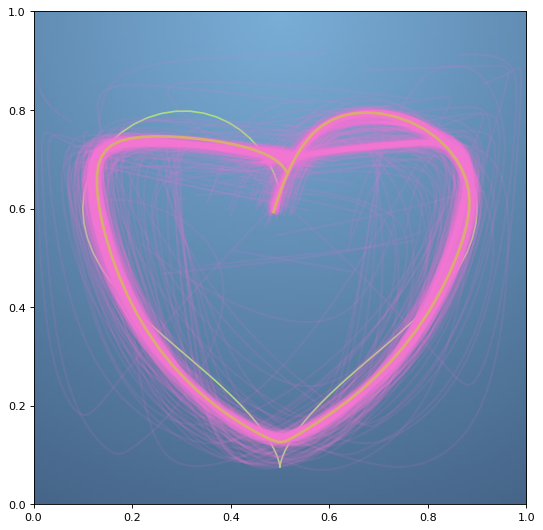

In [7]:
plot_training(x, y, iterations=50000, aggression=7, noise=1)